# Extend the Palma model using KG


In [1]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import seaborn as sns
from matplotlib.colors import ListedColormap

sys.path.append('./src')
import BNMPy

network_file = '../input_files/Palma2021.txt' # contains the phenotype nodes
network_file_no_phenotype = '../input_files/Palma2021_no_phenotype.txt' # no phenotype nodes

Using the stable states, the phenotype scores are calculated as in the original publication:
- Apoptosis = TP53 - BCL2
- Differentiation =	CEBPA + ETV6 - MEIS1
- Proliferation	= MYC + CCND1 + SOX4 + MEIS1 + STAT5A
- Network score = Proliferation - Differentiation - Apoptosis 

Network score = MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53  
The theoretical range of the network score is [-2, 8]

In [3]:
network = BNMPy.load_network(network_file_no_phenotype)
genes = network.nodeDict.keys()

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.


In [4]:
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&')
print(KG_string)

number of genes found: 18
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157]
AKT1 = (AKT1) & (FLT3) # Scores: AKT1_activate:0.2; FLT3_activate:0.431
BCL2 = (MAPK1) & (! GSK3B) & (! TP53) # Scores: MAPK1_activate:0.551; GSK3B_inhibit:0.2; TP53_inhibit:0.748
CCND1 = (! GSK3B) & (MYC) & (! DNMT3A) # Scores: GSK3B_inhibit:0.783; MYC_activate:0.495; DNMT3A_inhibit:0.504
CDKN2A = (! MYC) & (! DNMT3A) # Scores: MYC_inhibit:0.765; DNMT3A_inhibit:0.378
CEBPA = (! MAPK1) & (GSK3B) & (! FLT3) & (CEBPA) # Scores: MAPK1_inhibit:0.352; GSK3B_activate:0.38; FLT3_inhibit:0.631; CEBPA_activate:0.2
DNMT3A = (MYC) & (STAT5A) # Scores: MYC_activate:0.711; STAT5A_activate:0.326
ETV6 = (! MAPK1) # Scores: MAPK1_inhibit:0.317
FBXW7 = (AKT1) & (NPM1) # Scores: AKT1_activate:0.41; NPM1_activate:0.483
FLT3 = (FLT3) # Scores: FLT3_activate:0.2
GSK3B = (! AKT1) & (! MAPK1) & (GSK3B) # Scores: AKT1_inhibit:0.793; MAPK1_inhibit:0.384; GSK3B_activate:0.2
HOXA9 

In [11]:
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&', score_cutoff=0.3)
print(KG_string)

Applied score cutoff 0.3, filtered to 29565/40940 edges
number of genes found: 18
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157]
AKT1 = (FLT3) # Scores: FLT3_activate:0.431
BCL2 = (MAPK1) & (! TP53) # Scores: MAPK1_activate:0.551; TP53_inhibit:0.748
CCND1 = (! GSK3B) & (MYC) & (! DNMT3A) # Scores: GSK3B_inhibit:0.783; MYC_activate:0.495; DNMT3A_inhibit:0.504
CDKN2A = (! MYC) & (! DNMT3A) # Scores: MYC_inhibit:0.765; DNMT3A_inhibit:0.378
CEBPA = (! MAPK1) & (GSK3B) & (! FLT3) # Scores: MAPK1_inhibit:0.352; GSK3B_activate:0.38; FLT3_inhibit:0.631
DNMT3A = (MYC) & (STAT5A) # Scores: MYC_activate:0.711; STAT5A_activate:0.326
ETV6 = (! MAPK1) # Scores: MAPK1_inhibit:0.317
FBXW7 = (AKT1) & (NPM1) # Scores: AKT1_activate:0.41; NPM1_activate:0.483
FLT3 = FLT3
GSK3B = (! AKT1) & (! MAPK1) # Scores: AKT1_inhibit:0.793; MAPK1_inhibit:0.384
HOXA9 = (! NPM1) & (! DNMT3A) # Scores: NPM1_inhibit:0.351; DNMT3A_inhibit:0.338
MAPK1 = (AKT1) # S

In [5]:
# Merge the networks using PBN
KG = BNMPy.load_network_from_string(KG_string)
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.4
AKT1 = FLT3, 0.6
BCL2 = !GSK3B & MAPK1 & !TP53, 0.4
BCL2 = MAPK1 & !TP53, 0.6
CCND1 = ! ( DNMT3A | GSK3B ), 0.6
CCND1 = !DNMT3A & !GSK3B & MYC, 0.4
CDKN2A = !DNMT3A & !MYC, 0.4
CDKN2A = NPM1, 0.6
CEBPA = !FLT3, 0.6
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.4
DNMT3A = DNMT3A, 0.6
DNMT3A = MYC & STAT5A, 0.4
ETV6 = !MAPK1, 1.0
FBXW7 = AKT1 & NPM1, 0.4
FBXW7 = NPM1, 0.6
FLT3 = FLT3, 1.0
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.4
GSK3B = !AKT1, 0.6
HOXA9 = !DNMT3A & !NPM1, 0.4
HOXA9 = !NPM1, 0.6
MAPK1 = AKT1 & MAPK1, 0.4
MAPK1 = FLT3, 0.6
MEIS1 = !DNMT3A & HOXA9, 1.0
MYC = !CEBPA & !FBXW7 & FLT3 & !GSK3B & MAPK1, 0.4
MYC = MAPK1 & ( !FBXW7 | !GSK3B ), 0.6
NPM1 = !AKT1, 0.4
NPM1 = NPM1, 0.6
SOX4 = !CEBPA, 1.0
STAT5A = FLT3 & MAPK1, 0.4
STAT5A 

In [9]:
BNMPy.vis_network(pbn, interactive=True)

Network visualization saved to network_graph.html


## Data - BeatAML
805 patients (942 specimens) in total. 
> For DNA sequencing, we used the 11.9 megabase custom capture library that was developed to provide coverage of all variants previously reported in AML (including all variants that were detected from exome sequencing in our prior study).

Mutation, clinical data and drug response data are downloaded from the [BeatAML2 website](https://biodev.github.io/BeatAML2/):
1. [WES/targeted Sequencing Mutation Calls](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt)
2. [Clinical Summary](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx)
3. [Inhibitor AUC values](https://github.com/biodev/beataml2.0_data/raw/main/beataml_probit_curve_fits_v4_dbgap.txt)
4. [Inhibitor Families](https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx)

We identify the patients' mutation profiles using all identified mutations in the dataset, with a filter of significant SIFT and Polyphen score to include only the mutations that might alter protein functions. 
  
Then we set the fix values of the models according to the mutation profiles and run simulations to compute the list of logical stable states of the model. We have refered to literatures to classify the genes into oncogenes and tumor suppressor genes (TSGs), the mutated oncogenes are set to a fix value of 1; and the mutated TSGs are set to 0.  

Then we use the derived network scores as a proxy to the blast percentage in peripheral blood (PB_blast) and bone marrow (BM_blast), and train the model to predict the blast percentage using the network scores.  

In [6]:
# Read the data
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")
classification = pd.read_csv("../input_files/Palma_class.csv")

# Process the dataset
# Merge the df based on sample id
df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
df['survivalYears'] = df['ageAtDiagnosis'] + df['overallSurvival']/365

# Add FLT3-ITD
flt3_positive_df = df[df['FLT3-ITD'] == 'positive'].copy()
flt3_positive_df['symbol'] = 'FLT3'

clinical_df = pd.concat([df, flt3_positive_df], ignore_index=True)

# Filter the mutations that would alter protein functions
df = clinical_df[
    (clinical_df['symbol'].isin(pbn.nodeDict.keys())) &
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]

patient_to_mutations = df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()
patient_to_mutations.rename(columns={'symbol': 'profile'}, inplace=True)

# Convert blast percentage to numeric, coercing errors to NaN
profile_df = df.copy()
profile_df = profile_df.merge(patient_to_mutations, on='dbgap_subject_id', how='left')
profile_df['%.Blasts.in.BM'] = pd.to_numeric(profile_df['%.Blasts.in.BM'], errors='coerce')
profile_df['%.Blasts.in.PB'] = pd.to_numeric(profile_df['%.Blasts.in.PB'], errors='coerce')

# Aggregate for each patient
profile_df = profile_df.groupby('dbgap_subject_id').agg({
    '%.Blasts.in.BM': 'mean', 
    '%.Blasts.in.PB': 'mean',
    'profile': 'first'
}).reset_index()
profile_df

,dbgap_subject_id,%.Blasts.in.BM,%.Blasts.in.PB,profile
0,2000,10.0,1.0,{FLT3}
1,2003,NaN,50.0,{FLT3}
2,2005,50.0,NaN,{TP53}
3,2007,93.0,99.0,{DNMT3A}
4,2008,17.0,5.3,{DNMT3A}
...,...,...,...,...
310,2829,50.5,53.0,{TP53}
311,2831,NaN,NaN,{FLT3}
312,2832,26.0,NaN,{DNMT3A}
313,2834,95.0,NaN,{TP53}


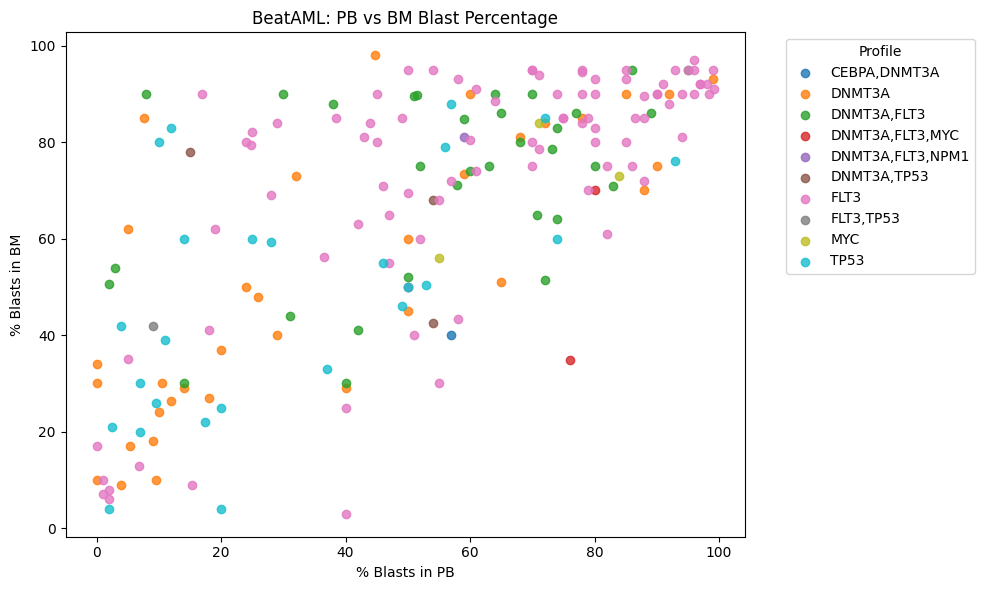

In [85]:
import matplotlib.pyplot as plt

profile_df = profile_df.copy()
profile_df['_profile_key'] = profile_df['profile'].apply(lambda s: ",".join(sorted(list(s))))
df = profile_df.dropna(subset=['%.Blasts.in.PB','%.Blasts.in.BM'])

plt.figure(figsize=(10,6))
for k, sub in df.groupby('_profile_key'):
    plt.scatter(sub['%.Blasts.in.PB'], sub['%.Blasts.in.BM'], label=k, alpha=0.8)
plt.xlabel('% Blasts in PB')
plt.ylabel('% Blasts in BM')
plt.title('BeatAML: PB vs BM Blast Percentage')
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
pb_stats = (profile_df.groupby('_profile_key')['%.Blasts.in.PB']
             .agg(n='size', min='min', max='max', avg='mean', var='var')
             .reset_index()
             .sort_values('n', ascending=False))
pb_statss

,_profile_key,n,min,max,avg,var
9,FLT3,141,0.0,99.2,61.893204,808.270836
2,DNMT3A,59,0.0,99.0,38.680000,1040.998118
3,"DNMT3A,FLT3",56,2.0,95.0,56.865447,617.302614
13,TP53,41,2.0,93.0,31.351852,688.335670
6,"DNMT3A,TP53",4,15.0,54.0,41.000000,507.000000
11,MYC,4,55.0,84.0,70.000000,211.000000
0,CEBPA,2,NaN,NaN,NaN,NaN
4,"DNMT3A,FLT3,MYC",2,76.0,80.0,78.000000,8.000000
1,"CEBPA,DNMT3A",1,57.0,57.0,57.000000,NaN
5,"DNMT3A,FLT3,NPM1",1,59.0,59.0,59.000000,NaN


In [74]:
bm_stats = (profile_df.groupby('_profile_key')['%.Blasts.in.BM']
             .agg(n='size', min='min', max='max', avg='mean', var='var')
             .reset_index()
             .sort_values('n', ascending=False))
bm_stats

,_profile_key,n,min,max,avg,var
9,FLT3,141,3.000000,97.0,73.442514,661.086296
2,DNMT3A,59,0.500000,98.0,45.664242,924.733533
3,"DNMT3A,FLT3",56,30.000000,95.0,69.627398,346.118280
13,TP53,41,4.000000,95.0,46.082353,624.421497
6,"DNMT3A,TP53",4,15.000000,78.0,50.875000,795.395833
11,MYC,4,3.000000,84.0,54.000000,1288.666667
0,CEBPA,2,40.000000,63.0,51.500000,264.500000
4,"DNMT3A,FLT3,MYC",2,34.833333,70.0,52.416667,618.347222
1,"CEBPA,DNMT3A",1,40.000000,40.0,40.000000,NaN
5,"DNMT3A,FLT3,NPM1",1,81.000000,81.0,81.000000,NaN


In [ ]:
# Build experiments CSVs for optimizer
def _parse_profile(cell):
    genes = list(cell)
    return sorted({g.strip() for g in genes if g and isinstance(g, str)})

def _profile_key(genes_list):
    # Stable canonical key for grouping
    return ",".join(sorted(genes_list))

def build_experiments(profile_df, classification_df, target_col):
    # Expect columns: 'profile' (set/list/string of genes) and target_col (numeric)
    df = profile_df.copy()
    df = df.dropna(subset=['profile'])
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df = df.dropna(subset=[target_col])

    # Parse profiles to canonical keys
    parsed = df['profile'].apply(_parse_profile)
    df['_profile_genes'] = parsed
    df['_profile_key'] = parsed.apply(_profile_key)

    # Average the target across patients with same profile
    avg_df = (
        df.groupby('_profile_key', as_index=False)
          .agg({target_col: 'mean'})
    )

    # Attach a representative gene list for each profile key
    rep_genes = (
        df.drop_duplicates('_profile_key')[['_profile_key', '_profile_genes']]
    )
    avg_df = avg_df.merge(rep_genes, on='_profile_key', how='left')

    # Stimuli/Inhibitors from classification across all genes in profile
    gene_to_class = dict(zip(classification_df['symbol'], classification_df['class']))

    def classify_profile(genes):
        oncogenes = [g for g in genes if gene_to_class.get(g, '').lower() == 'oncogene']
        tsgs = [g for g in genes if gene_to_class.get(g, '').lower() == 'tsg']
        return (
            ",".join(sorted(oncogenes)),
            ",".join(sorted(tsgs)),
            '1' if oncogenes else '',
            '1' if tsgs else ''
        )

    stim, inhib, stim_eff, inhib_eff = [], [], [], []
    for genes in avg_df['_profile_genes']:
        s, i, se, ie = classify_profile(genes or [])
        stim.append(s); inhib.append(i); stim_eff.append(se); inhib_eff.append(ie)

    avg_df['Stimuli'] = stim
    avg_df['Inhibitors'] = inhib

    # Measured node/value (normalize blasts based on the range of the network score, 0 to 5)
    col = avg_df[target_col]
    # print(col)
    min_val, max_val = col.min(), col.max()
    # measured = (col - min_val) * 5 / (max_val - min_val)
    measured = col # no normalization for blast percentage
    # print(measured)
    avg_df['Measured_nodes'] = target_col
    avg_df['Measured_values'] = measured.round(4).astype(str)

    # Experiments index
    avg_df['Experiments'] = np.arange(1, len(avg_df) + 1)

    return avg_df[['Experiments', 'Stimuli', 'Inhibitors',
                   'Measured_nodes', 'Measured_values']].sort_values('Experiments', ascending=True)

# Build for PB and BM and save
experiments_pb = build_experiments(profile_df, classification, '%.Blasts.in.PB')
experiments_bm = build_experiments(profile_df, classification, '%.Blasts.in.BM')

experiments_pb.to_csv('../data/BeatAML_PB_experiments.csv', index=False)
experiments_bm.to_csv('../data/BeatAML_BM_experiments.csv', index=False)

## Optimize the extended PBN using BeatAML data

In [4]:
# optimizer configuration
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 1000,
        'popsize': 20,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1.5),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'seed': 9
}

### Blast percentage in PB

In [6]:
# AND
optimizer_pb = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_PB_experiments.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53',
    normalize=True,
    verbose=False)

# Run optimization
result_pb = optimizer_pb.optimize(method='differential_evolution')

Normalization enabled: Measured values range [9.0000, 78.0000] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 1000/1000 | Best MSE: 0.015681 | Conv: 0.0199

--- Optimization finished. Best MSE found: 0.015681 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.9951
AKT1 = FLT3, 0.0049
BCL2 = !GSK3B & MAPK1 & !TP53, 0.9991
BCL2 = MAPK1 & !TP53, 0.0009
CCND1 = ! ( DNMT3A | GSK3B ), 0.0006
CCND1 = !DNMT3A & !GSK3B & MYC, 0.9994
CDKN2A = !DNMT3A & !MYC, 0.5475
CDKN2A = NPM1, 0.4525
CEBPA = !FLT3, 0.0024
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.9976
DNMT3A = DNMT3A, 0.7806
DNMT3A = MYC & STAT5A, 0.2194
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.0032
FBXW7 = NPM1, 0.9968
FLT3 = FLT3, 1.0000
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.0124
GSK3B = !AKT1, 0.9876
HOXA9 = !DNMT3A & !NPM1, 0.3017
HOXA9 = !NPM1, 0.6983
MAPK1 = AKT1 & MAPK1, 0.4374
MAPK1 = FLT3, 0.5626
MEIS1 = !DNMT3A & HOXA9, 1.0000
MYC = !CEBPA & !FBXW7 & FLT3 &

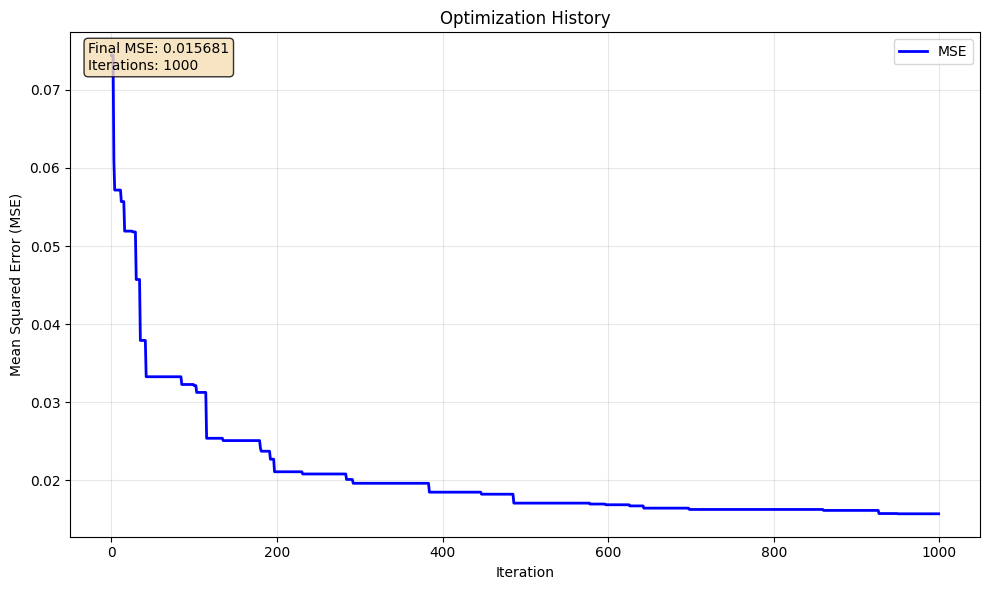

In [7]:
optimizer_pb.plot_optimization_history(result_pb)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=3.0400, measured=57.0000)
  Experiment 2: Formula measurement (predicted=2.8800, measured=38.6800)
  Experiment 3: Formula measurement (predicted=2.8900, measured=56.8654)
  Experiment 4: Formula measurement (predicted=3.4973, measured=78.0000)
  Experiment 5: Formula measurement (predicted=3.0800, measured=59.0000)
  Experiment 6: Formula measurement (predicted=2.8900, measured=41.0000)
  Experiment 7: Formula measurement (predicted=3.1352, measured=61.8932)
  Experiment 8: Formula measurement (predicted=2.2200, measured=9.0000)
  Experiment 9: Formula measurement (predicted=3.2935, measured=70.0000)
  Experiment 10: Formula measurement (predicted=2.1100, measured=31.3519)
Simulation completed: 10 data points
Plot saved to BeatAML_PB_phenotype_score_0-1_DE_AND/prediction_vs_experimental.png
Residual plot saved to BeatAML_PB_phenotype_score_0-1_DE_AND/residual_analysis.png
Evalua

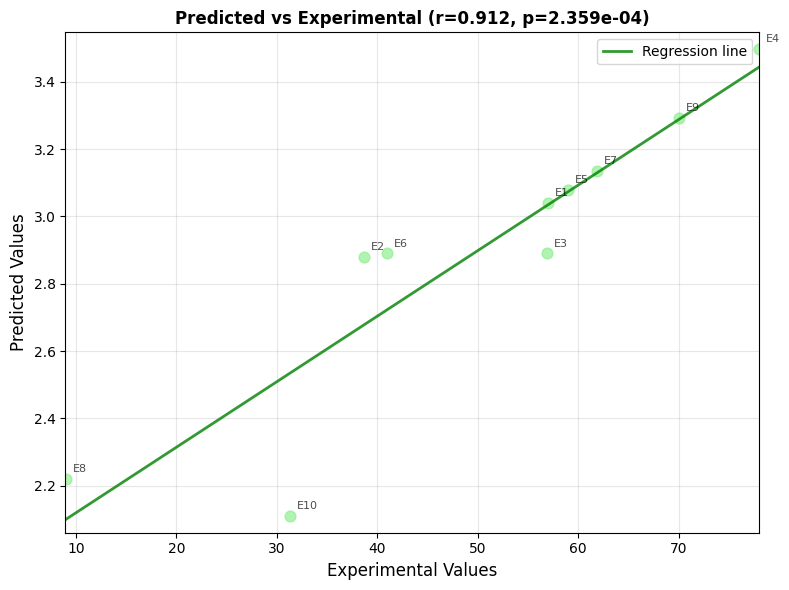

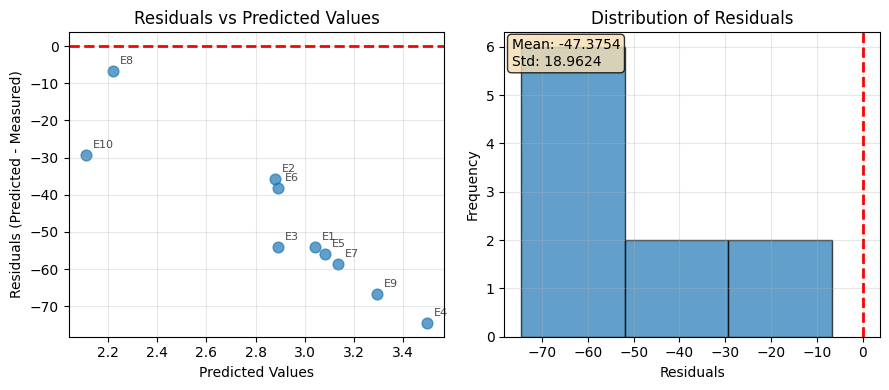

In [8]:
pbn_pb = optimizer_pb.get_optimized_pbn(result_pb)
np.random.seed(9)
output_dir = "BeatAML_PB_phenotype_score_0-1_DE_AND"
evaluator = BNMPy.evaluate_optimization_result(
    result_pb, 
    optimizer_pb, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

### Blast percentage in BM


In [10]:
# AND
optimizer_bm = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_BM_experiments.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53',
    normalize=True,
    verbose=False)

# Run optimization
result_bm = optimizer_bm.optimize(method='differential_evolution')

Normalization enabled: Measured values range [40.0000, 81.0000] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 1000/1000 | Best MSE: 0.027926 | Conv: 0.0141

--- Optimization finished. Best MSE found: 0.027926 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.9801
AKT1 = FLT3, 0.0199
BCL2 = !GSK3B & MAPK1 & !TP53, 0.0612
BCL2 = MAPK1 & !TP53, 0.9388
CCND1 = ! ( DNMT3A | GSK3B ), 0.0512
CCND1 = !DNMT3A & !GSK3B & MYC, 0.9488
CDKN2A = !DNMT3A & !MYC, 0.3601
CDKN2A = NPM1, 0.6399
CEBPA = !FLT3, 0.0032
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.9968
DNMT3A = DNMT3A, 0.4183
DNMT3A = MYC & STAT5A, 0.5817
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.6631
FBXW7 = NPM1, 0.3369
FLT3 = FLT3, 1.0000
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.0637
GSK3B = !AKT1, 0.9363
HOXA9 = !DNMT3A & !NPM1, 0.0154
HOXA9 = !NPM1, 0.9846
MAPK1 = AKT1 & MAPK1, 0.9906
MAPK1 = FLT3, 0.0094
MEIS1 = !DNMT3A & HOXA9, 1.0000
MYC = !CEBPA & !FBXW7 & FLT3 

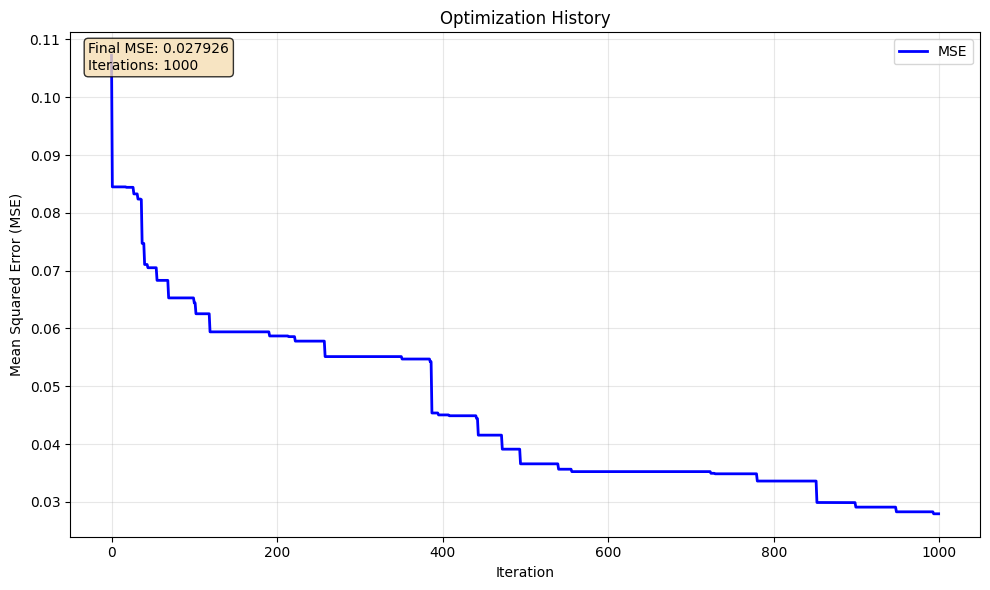

In [11]:
optimizer_bm.plot_optimization_history(result_bm)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=2.9100, measured=51.5000)
  Experiment 2: Formula measurement (predicted=2.5500, measured=40.0000)
  Experiment 3: Formula measurement (predicted=3.0100, measured=45.6642)
  Experiment 4: Formula measurement (predicted=3.3900, measured=69.6274)
  Experiment 5: Formula measurement (predicted=2.7993, measured=52.4167)
  Experiment 6: Formula measurement (predicted=4.7100, measured=81.0000)
  Experiment 7: Formula measurement (predicted=3.7500, measured=50.8750)
  Experiment 8: Formula measurement (predicted=3.3346, measured=60.1000)
  Experiment 9: Formula measurement (predicted=3.7369, measured=73.4425)
  Experiment 10: Formula measurement (predicted=2.5200, measured=42.0000)
  Experiment 11: Formula measurement (predicted=3.2100, measured=54.0000)
  Experiment 12: Formula measurement (predicted=2.1200, measured=46.0824)
Simulation completed: 12 data points
Plot saved to BeatAML_B

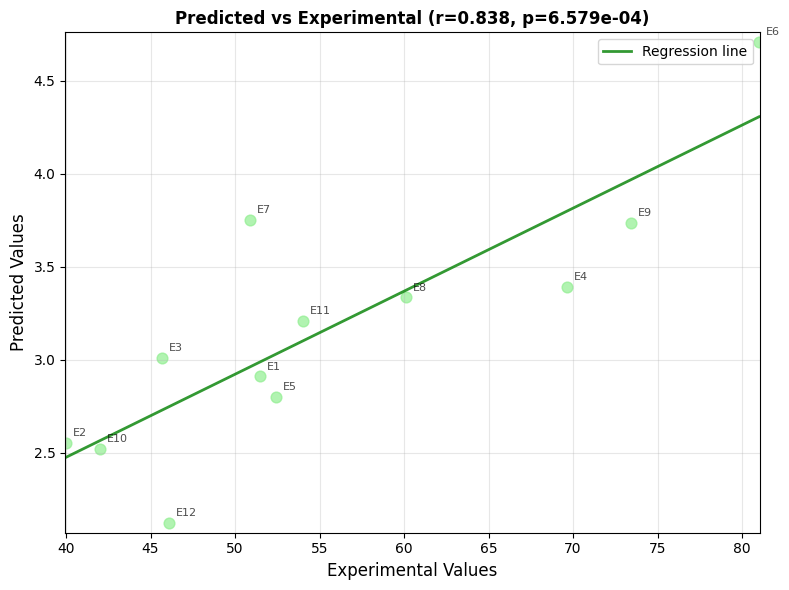

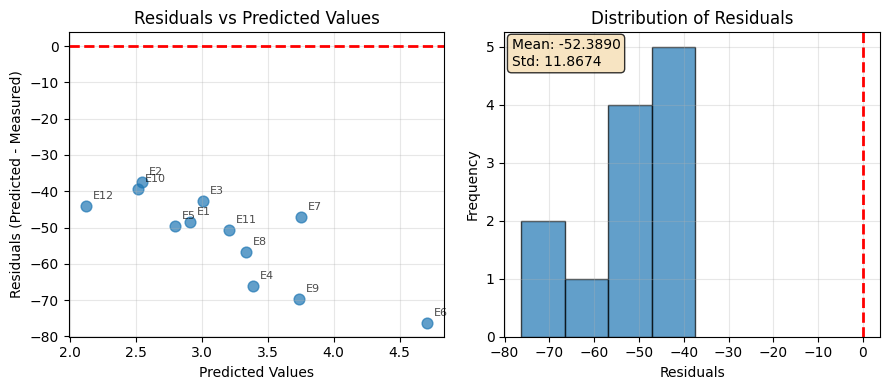

In [12]:
np.random.seed(9)
output_dir = "BeatAML_BM_phenotype_score_0-1_DE_AND"
evaluator = BNMPy.evaluate_optimization_result(
    result_bm, 
    optimizer_bm, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

## Three alternative rules?

Add both the AND, OR and inhibitor wins rules to the model.

In [9]:
KG_OR_string, relations = BNMPy.load_signor_network(genes, joiner='|')
KG_AND_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG_IW_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')

KG_OR = BNMPy.load_network_from_string(KG_OR_string)
KG_AND = BNMPy.load_network_from_string(KG_AND_string)
KG_IW = BNMPy.load_network_from_string(KG_IW_string)

pbn_string = BNMPy.merge_networks([network, KG_OR, KG_AND, KG_IW], method="PBN", prob=0.25)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

number of genes found: 18
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157]
number of genes found: 18
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157]
number of genes found: 18
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.25
AKT1 = AKT1 | FLT3, 0.5
AKT1 = FLT3, 0.25
BCL2 = !GSK3B & MAPK1 & !TP53, 0.5
BCL2 = !GSK3B | MAPK1 |

### PB Blast

In [28]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 1000,
        'popsize': 20,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1.5),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.09, # threshold for accepting fit,
    'display_rules_every': 100,  # Display optimized rules every n iterations (0 = disabled)
    'seed': 9
    }

In [29]:
# AND + OR + IW
optimizer_pb = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_PB_experiments.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53',
    normalize=True,
    verbose=True)

# Run optimization
result_pb = optimizer_pb.optimize(method='differential_evolution')

Normalization enabled: Measured values range [9.0000, 78.0000] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


DE Setup:
  - Max iterations: 1000
  - Population size: 20
  - Tolerance: 0.001
  - Absolute tolerance: 0
  - Mutation: (0.5, 1.5)
  - Recombination: 0.7
  - Early stopping: False
  - Seed: 9


/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 1: Current MSE: 0.146950, Best MSE so far: 0.146950, Convergence: 0.0065
Iteration 2: Current MSE: 0.139590, Best MSE so far: 0.139590, Convergence: 0.0067
Iteration 3: Current MSE: 0.139590, Best MSE so far: 0.139590, Convergence: 0.0071


/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 4: Current MSE: 0.139590, Best MSE so far: 0.139590, Convergence: 0.0076


/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 5: Current MSE: 0.139590, Best MSE so far: 0.139590, Convergence: 0.0081
Iteration 6: Current MSE: 0.139590, Best MSE so far: 0.139590, Convergence: 0.0085


/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 7: Current MSE: 0.139590, Best MSE so far: 0.139590, Convergence: 0.0090
Iteration 8: Current MSE: 0.133953, Best MSE so far: 0.133953, Convergence: 0.0096
Iteration 9: Current MSE: 0.133953, Best MSE so far: 0.133953, Convergence: 0.0101
Iteration 10: Current MSE: 0.133953, Best MSE so far: 0.133953, Convergence: 0.0109
Iteration 11: Current MSE: 0.133953, Best MSE so far: 0.133953, Convergence: 0.0112
Iteration 12: Current MSE: 0.133953, Best MSE so far: 0.133953, Convergence: 0.0120
Iteration 13: Current MSE: 0.132853, Best MSE so far: 0.132853, Convergence: 0.0128
Iteration 14: Current MSE: 0.132298, Best MSE so far: 0.132298, Convergence: 0.0133
Iteration 15: Current MSE: 0.131575, Best MSE so far: 0.131575, Convergence: 0.0137
Iteration 16: Current MSE: 0.131575, Best MSE so far: 0.131575, Convergence: 0.0140
Iteration 17: Current MSE: 0.131575, Best MSE so far: 0.131575, Convergence: 0.0144
Iteration 18: Current MSE: 0.131575, Best MSE so far: 0.131575, Convergence: 0.

/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 19: Current MSE: 0.128660, Best MSE so far: 0.128660, Convergence: 0.0148
Iteration 20: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0154
Iteration 21: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0158
Iteration 22: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0162
Iteration 23: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0163
Iteration 24: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0165
Iteration 25: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0166
Iteration 26: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0170


/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 27: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0175
Iteration 28: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0179
Iteration 29: Current MSE: 0.125529, Best MSE so far: 0.125529, Convergence: 0.0183
Iteration 30: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0186
Iteration 31: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0186
Iteration 32: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0185
Iteration 33: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0185
Iteration 34: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0188
Iteration 35: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0187
Iteration 36: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0188
Iteration 37: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence: 0.0189
Iteration 38: Current MSE: 0.118813, Best MSE so far: 0.118813, Convergence:

/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 44: Current MSE: 0.115650, Best MSE so far: 0.115650, Convergence: 0.0200
Iteration 45: Current MSE: 0.115650, Best MSE so far: 0.115650, Convergence: 0.0201
Iteration 46: Current MSE: 0.115650, Best MSE so far: 0.115650, Convergence: 0.0202
Iteration 47: Current MSE: 0.115650, Best MSE so far: 0.115650, Convergence: 0.0203
Iteration 48: Current MSE: 0.115650, Best MSE so far: 0.115650, Convergence: 0.0204
Iteration 49: Current MSE: 0.114365, Best MSE so far: 0.114365, Convergence: 0.0208
Iteration 50: Current MSE: 0.114298, Best MSE so far: 0.114298, Convergence: 0.0210


/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 51: Current MSE: 0.111520, Best MSE so far: 0.111520, Convergence: 0.0212
Iteration 52: Current MSE: 0.111520, Best MSE so far: 0.111520, Convergence: 0.0215
Iteration 53: Current MSE: 0.111520, Best MSE so far: 0.111520, Convergence: 0.0215
Iteration 54: Current MSE: 0.111520, Best MSE so far: 0.111520, Convergence: 0.0216
Iteration 55: Current MSE: 0.111520, Best MSE so far: 0.111520, Convergence: 0.0220
Iteration 56: Current MSE: 0.111520, Best MSE so far: 0.111520, Convergence: 0.0220
Iteration 57: Current MSE: 0.110691, Best MSE so far: 0.110691, Convergence: 0.0224
Iteration 58: Current MSE: 0.110691, Best MSE so far: 0.110691, Convergence: 0.0223
Iteration 59: Current MSE: 0.110691, Best MSE so far: 0.110691, Convergence: 0.0224
Iteration 60: Current MSE: 0.110691, Best MSE so far: 0.110691, Convergence: 0.0225
Iteration 61: Current MSE: 0.110691, Best MSE so far: 0.110691, Convergence: 0.0227
Iteration 62: Current MSE: 0.110691, Best MSE so far: 0.110691, Convergence:

/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 105: Current MSE: 0.095253, Best MSE so far: 0.095253, Convergence: 0.0219
Iteration 106: Current MSE: 0.095253, Best MSE so far: 0.095253, Convergence: 0.0218
Iteration 107: Current MSE: 0.095253, Best MSE so far: 0.095253, Convergence: 0.0218
Iteration 108: Current MSE: 0.095253, Best MSE so far: 0.095253, Convergence: 0.0219
Iteration 109: Current MSE: 0.095253, Best MSE so far: 0.095253, Convergence: 0.0220
Iteration 110: Current MSE: 0.095253, Best MSE so far: 0.095253, Convergence: 0.0217
Iteration 111: Current MSE: 0.094746, Best MSE so far: 0.094746, Convergence: 0.0207
Iteration 112: Current MSE: 0.091955, Best MSE so far: 0.091955, Convergence: 0.0198
Iteration 113: Current MSE: 0.091955, Best MSE so far: 0.091955, Convergence: 0.0198
Iteration 114: Current MSE: 0.091955, Best MSE so far: 0.091955, Convergence: 0.0195
Iteration 115: Current MSE: 0.091955, Best MSE so far: 0.091955, Convergence: 0.0195
Iteration 116: Current MSE: 0.091955, Best MSE so far: 0.091955, 

/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))


Iteration 193: Current MSE: 0.085261, Best MSE so far: 0.085261, Convergence: 0.0227
Iteration 194: Current MSE: 0.085261, Best MSE so far: 0.085261, Convergence: 0.0226
Iteration 195: Current MSE: 0.085261, Best MSE so far: 0.085261, Convergence: 0.0228
Iteration 196: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0233
Iteration 197: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0235
Iteration 198: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0236
Iteration 199: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0235
Iteration 201: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0240
Iteration 202: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0243
Iteration 203: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0244
Iteration 204: Current MSE: 0.084999, Best MSE so far: 0.084999, Convergence: 0.0246
Iteration 205: Current MSE: 0.084999, Best MSE so far: 0.084999, 

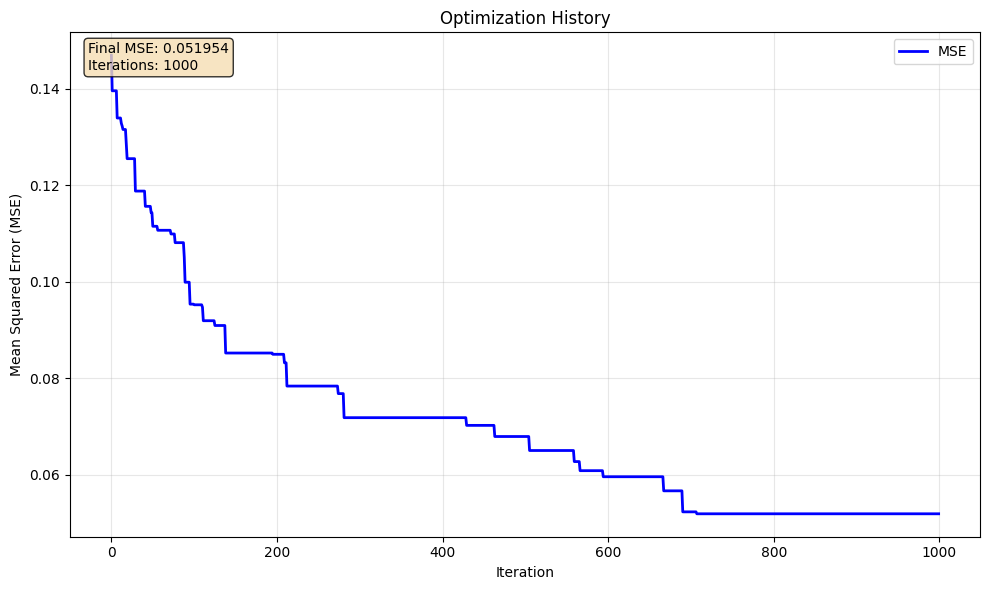

In [31]:
optimizer_pb.plot_optimization_history(result_pb)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=4.0500, measured=57.0000)
  Experiment 2: Formula measurement (predicted=2.6373, measured=38.6800)
  Experiment 3: Formula measurement (predicted=2.6373, measured=56.8654)
  Experiment 4: Formula measurement (predicted=4.1345, measured=78.0000)
  Experiment 5: Formula measurement (predicted=3.2100, measured=59.0000)
  Experiment 6: Formula measurement (predicted=3.3273, measured=41.0000)
  Experiment 7: Formula measurement (predicted=2.7729, measured=61.8932)
  Experiment 8: Formula measurement (predicted=2.1700, measured=9.0000)
  Experiment 9: Formula measurement (predicted=3.1800, measured=70.0000)
  Experiment 10: Formula measurement (predicted=1.5600, measured=31.3519)
Simulation completed: 10 data points
Plot saved to BeatAML_PB_phenotype_score_0-1_DE_AND+OR+IW/prediction_vs_experimental.png
Residual plot saved to BeatAML_PB_phenotype_score_0-1_DE_AND+OR+IW/residual_analysi

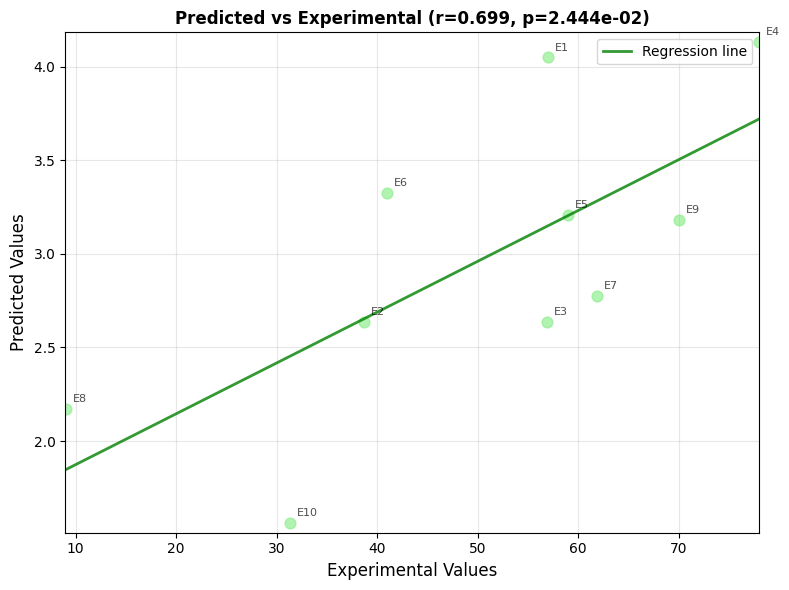

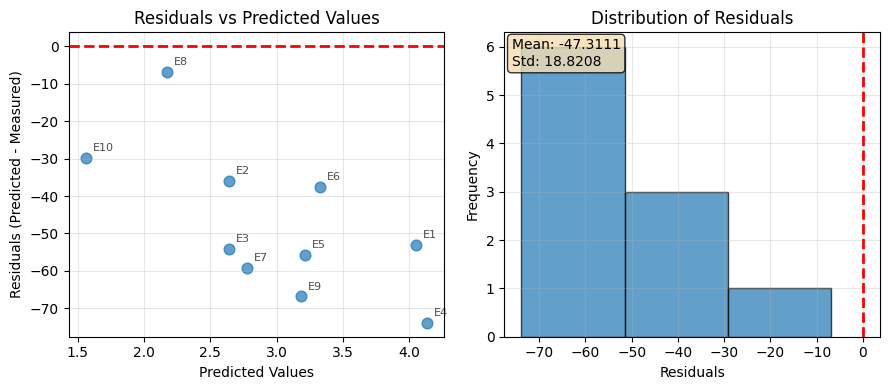

In [32]:
np.random.seed(9)
output_dir = "BeatAML_PB_phenotype_score_0-1_DE_AND+OR+IW"
evaluator = BNMPy.evaluate_optimization_result(
    result_pb, 
    optimizer_pb, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

### BM Blast

In [13]:
# AND + OR + IW
optimizer_bm2 = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_BM_experiments.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53',
    normalize=True,
    verbose=False)

# Run optimization
result_bm2 = optimizer_bm2.optimize(method='differential_evolution')

Normalization enabled: Measured values range [40.0000, 81.0000] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 1000/1000 | Best MSE: 0.027926 | Conv: 0.0141

--- Optimization finished. Best MSE found: 0.027926 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.9801
AKT1 = FLT3, 0.0199
BCL2 = !GSK3B & MAPK1 & !TP53, 0.0612
BCL2 = MAPK1 & !TP53, 0.9388
CCND1 = ! ( DNMT3A | GSK3B ), 0.0512
CCND1 = !DNMT3A & !GSK3B & MYC, 0.9488
CDKN2A = !DNMT3A & !MYC, 0.3601
CDKN2A = NPM1, 0.6399
CEBPA = !FLT3, 0.0032
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.9968
DNMT3A = DNMT3A, 0.4183
DNMT3A = MYC & STAT5A, 0.5817
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.6631
FBXW7 = NPM1, 0.3369
FLT3 = FLT3, 1.0000
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.0637
GSK3B = !AKT1, 0.9363
HOXA9 = !DNMT3A & !NPM1, 0.0154
HOXA9 = !NPM1, 0.9846
MAPK1 = AKT1 & MAPK1, 0.9906
MAPK1 = FLT3, 0.0094
MEIS1 = !DNMT3A & HOXA9, 1.0000
MYC = !CEBPA & !FBXW7 & FLT3 

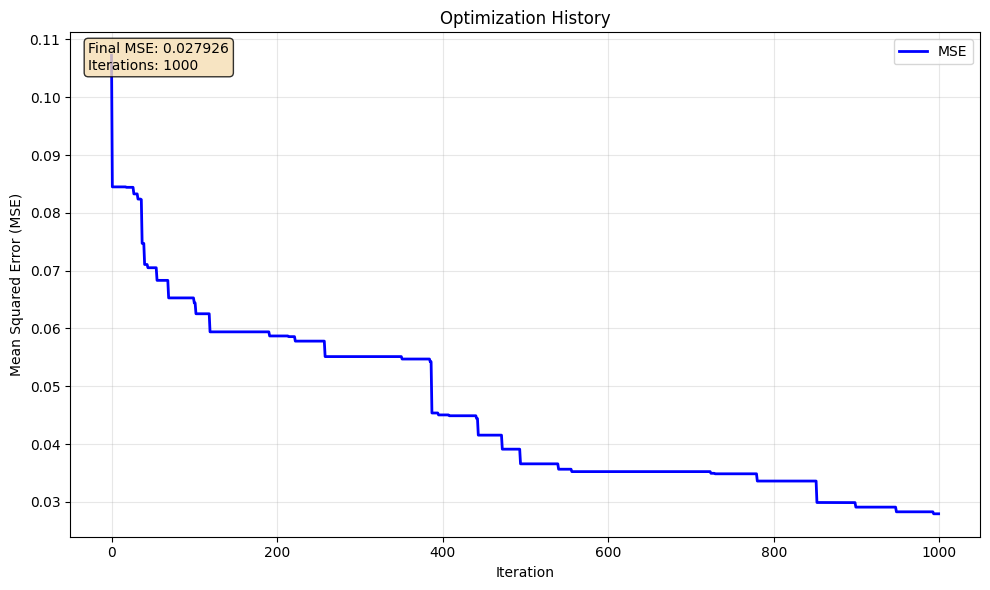

In [14]:
optimizer_bm.plot_optimization_history(result_bm)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=2.9100, measured=51.5000)
  Experiment 2: Formula measurement (predicted=2.5500, measured=40.0000)
  Experiment 3: Formula measurement (predicted=3.0100, measured=45.6642)
  Experiment 4: Formula measurement (predicted=3.3900, measured=69.6274)
  Experiment 5: Formula measurement (predicted=2.7993, measured=52.4167)
  Experiment 6: Formula measurement (predicted=4.7100, measured=81.0000)
  Experiment 7: Formula measurement (predicted=3.7500, measured=50.8750)
  Experiment 8: Formula measurement (predicted=3.3346, measured=60.1000)
  Experiment 9: Formula measurement (predicted=3.7369, measured=73.4425)
  Experiment 10: Formula measurement (predicted=2.5200, measured=42.0000)
  Experiment 11: Formula measurement (predicted=3.2100, measured=54.0000)
  Experiment 12: Formula measurement (predicted=2.1200, measured=46.0824)
Simulation completed: 12 data points
Plot saved to BeatAML_B

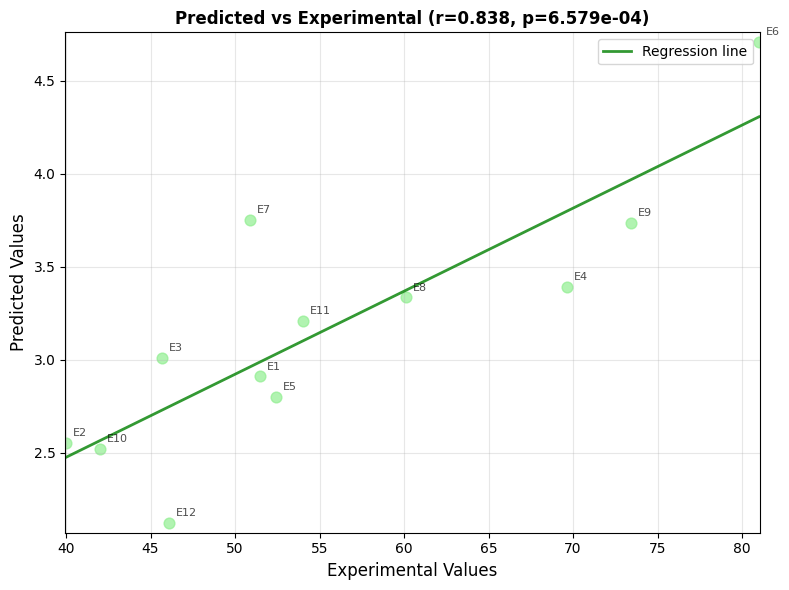

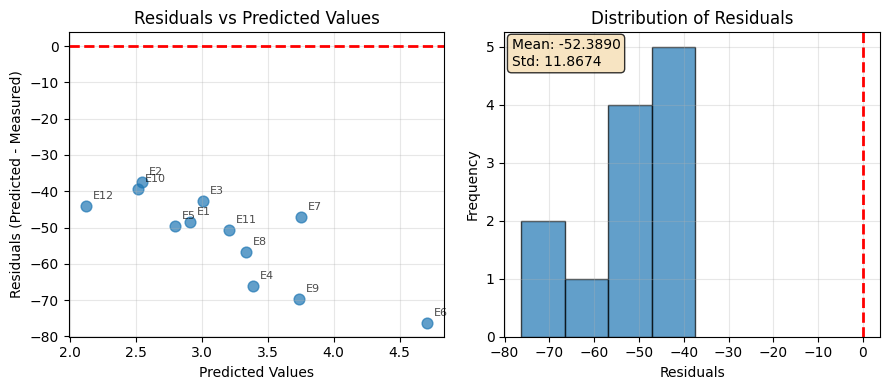

In [16]:
np.random.seed(9)
output_dir = "BeatAML_BM_phenotype_score_0-1_DE_AND+OR+IW"
evaluator = BNMPy.evaluate_optimization_result(
    result_bm, 
    optimizer_bm, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

# Test on other data

In [80]:
import pandas as pd
import numpy as np
import sys
import importlib
importlib.reload(sys.modules['BNMPy.result_evaluation'])
from BNMPy.result_evaluation import evaluate_optimization_result, evaluate_pbn

np.random.seed(9)
pbn_pb = BNMPy.load_network('./BeatAML_PB_phenotype_score_0-1_DE_AND/pbn.txt')
pbn_bm = BNMPy.load_network('./BeatAML_BM_phenotype_score_0-1_DE_AND/pbn.txt')

No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.


## TCGA
   
Mutation and clinical data are downloaded from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [76]:
# Data
tsv_file_path_genes = 'https://api.gdc.cancer.gov/data/0d8851d7-1af0-4054-a527-5db763138400'
tsv_file_path_clinical = 'https://api.gdc.cancer.gov/data/1fd61a91-90d5-405a-bcef-b9df8b396a21'

df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])
df_clinical = pd.read_csv(tsv_file_path_clinical, sep='\t', usecols=['bcr_patient_barcode', 
                                                            'lab_procedure_blast_cell_outcome_percentage_value',
                                                            'lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])
classification = pd.read_csv("../input_files/Palma_class.csv")

def _u(x): return str(x).strip().upper() if pd.notna(x) else x

dfg = df_genes.copy()
dfg['gene_name'] = dfg['gene_name'].map(_u)
dfg = dfg[dfg['gene_name'].isin(pbn.nodeDict.keys())]
dfc = df_clinical.copy()
dfc['bcr_patient_barcode'] = dfc['bcr_patient_barcode'].str.strip()

cls2 = classification.copy()
cls2['Gene'] = cls2['symbol'].map(_u)
cls2['Class'] = cls2['class'].str.strip().str.lower()
onc = set(cls2.loc[cls2['Class'] == 'oncogene', 'Gene'])
tsg = set(cls2.loc[cls2['Class'].isin(['tsg','tumor suppressor','tumour suppressor']), 'Gene'])

profiles = (
    dfg.groupby('TCGA_id')['gene_name']
       .agg(lambda s: sorted(set(g for g in s if isinstance(g, str) and g)))
       .reset_index()
       .rename(columns={'gene_name':'profile'})
)

tcga = (
    profiles.merge(dfc, left_on='TCGA_id', right_on='bcr_patient_barcode', how='left')
            .drop(columns=['bcr_patient_barcode'])
            .rename(columns={
                'lab_procedure_blast_cell_outcome_percentage_value':'PB_blast_pct',
                'lab_procedure_bone_marrow_blast_cell_outcome_percent_value':'BM_blast_pct'
            })
)
tcga

,TCGA_id,profile,PB_blast_pct,BM_blast_pct
0,TCGA-AB-2802,"[DNMT3A, NPM1]",88,52
1,TCGA-AB-2808,[CEBPA],59,0
2,TCGA-AB-2809,"[DNMT3A, NPM1]",60,0
3,TCGA-AB-2810,[NPM1],48,88
4,TCGA-AB-2811,"[DNMT3A, FLT3, NPM1]",98,37
...,...,...,...,...
120,TCGA-AB-3006,[FLT3],14,14
121,TCGA-AB-3007,[FLT3],90,7
122,TCGA-AB-3008,[CEBPA],71,90
123,TCGA-AB-3011,[NPM1],91,83


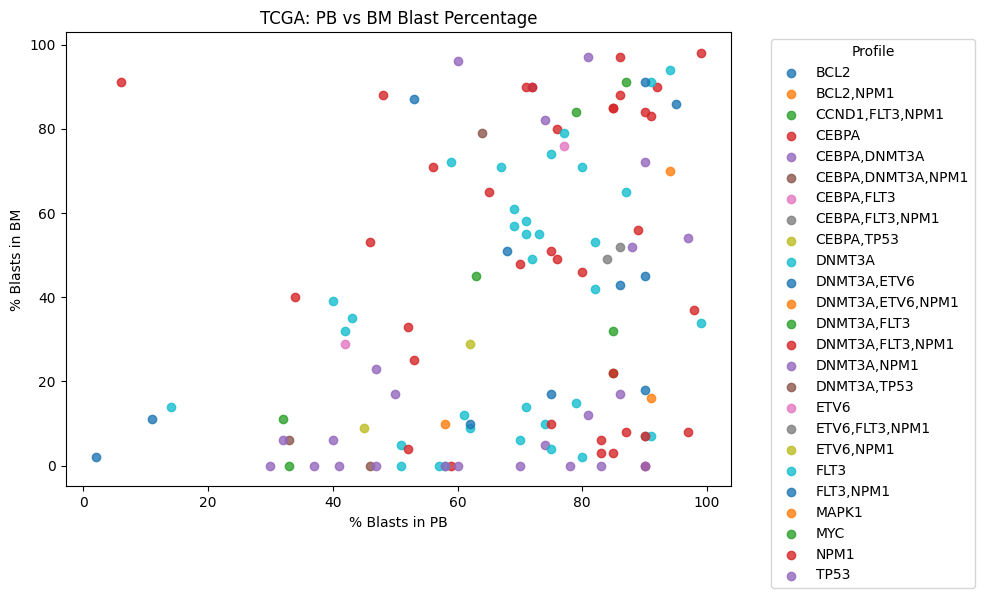

In [88]:
import matplotlib.pyplot as plt
tcga_df = tcga.copy()
tcga_df['_profile_key'] = tcga_df['profile'].apply(lambda s: ",".join(sorted(list(s))))
df = tcga_df.dropna(subset=['PB_blast_pct','BM_blast_pct'])

plt.figure(figsize=(10,6))
for k, sub in df.groupby('_profile_key'):
    plt.scatter(sub['PB_blast_pct'], sub['BM_blast_pct'], label=k, alpha=0.8)
plt.xlabel('% Blasts in PB')
plt.ylabel('% Blasts in BM')
plt.title('TCGA: PB vs BM Blast Percentage')
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
tcga['_profile_key'] = tcga['profile'].apply(lambda s: ",".join(sorted(list(s))))
pb_stats = (tcga.groupby('_profile_key')['PB_blast_pct']
             .agg(n='size', min='min', max='max', avg='mean', var='var')
             .reset_index()
             .sort_values('n', ascending=False))
pb_stats

,_profile_key,n,min,max,avg,var
19,FLT3,21,14,94,71.857143,332.028571
13,"DNMT3A,FLT3,NPM1",17,6,98,76.882353,528.360294
9,DNMT3A,14,42,99,65.571429,273.956044
24,TP53,13,30,97,60.692308,534.564103
23,NPM1,12,48,99,77.666667,243.515152
20,"FLT3,NPM1",9,11,95,72.444444,735.777778
14,"DNMT3A,NPM1",9,41,90,70.666667,316.250000
3,CEBPA,7,34,86,61.142857,274.142857
12,"DNMT3A,FLT3",5,32,87,73.600000,549.800000
15,"DNMT3A,TP53",2,33,46,39.500000,84.500000


In [79]:
bm_stats = (tcga.groupby('_profile_key')['BM_blast_pct']
             .agg(n='size', min='min', max='max', avg='mean', var='var')
             .reset_index()
             .sort_values('n', ascending=False))
bm_stats

,_profile_key,n,min,max,avg,var
19,FLT3,21,0,94,43.190476,932.361905
13,"DNMT3A,FLT3,NPM1",17,0,91,44.176471,1156.654412
9,DNMT3A,14,0,72,27.500000,717.038462
24,TP53,13,0,82,13.615385,644.589744
23,NPM1,12,3,98,56.083333,1519.901515
20,"FLT3,NPM1",9,10,91,45.333333,1182.250000
14,"DNMT3A,NPM1",9,0,90,28.777778,1172.194444
3,CEBPA,7,0,90,52.857143,1053.476190
12,"DNMT3A,FLT3",5,11,91,48.000000,1361.500000
15,"DNMT3A,TP53",2,0,6,3.000000,18.000000


In [ ]:
def stim_inhib(genes):
    genes = set(map(_u, genes or []))
    return ",".join(sorted(genes & onc)), ",".join(sorted(genes & tsg))

def build_csv(target_col, out_path):
    df = tcga.copy()
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df = df.dropna(subset=[target_col])
    if df.empty:
        pd.DataFrame(columns=['Experiments','Stimuli','Inhibitors','Measured_nodes','Measured_values']).to_csv(out_path, index=False)
        return df
    df[['Stimuli','Inhibitors']] = df['profile'].apply(lambda g: pd.Series(stim_inhib(g)))
    g = (df.groupby(['Stimuli','Inhibitors'], as_index=False)[target_col].mean())
    g = g.assign(
        Experiments=np.arange(1, len(g)+1),
        Measured_nodes=target_col,
        Measured_values=g[target_col].round(4).astype(str)
    )
    g[['Experiments','Stimuli','Inhibitors','Measured_nodes','Measured_values']].to_csv(out_path, index=False)
    return g

pb = build_csv('PB_blast_pct', '../data/TCGA_PB_experiments.csv')
bm = build_csv('BM_blast_pct', '../data/TCGA_BM_experiments.csv')

print(pb.shape, bm.shape)

(25, 6) (25, 6)


In [70]:
profiles

,TCGA_id,profile
0,TCGA-AB-2802,"[DNMT3A, NPM1]"
1,TCGA-AB-2809,"[DNMT3A, NPM1]"
2,TCGA-AB-2810,[NPM1]
3,TCGA-AB-2811,"[DNMT3A, FLT3, NPM1]"
4,TCGA-AB-2812,"[FLT3, NPM1]"
...,...,...
95,TCGA-AB-2994,[FLT3]
96,TCGA-AB-2998,"[DNMT3A, FLT3]"
97,TCGA-AB-3006,[FLT3]
98,TCGA-AB-3007,[FLT3]


In [81]:
evaluate_pbn(pbn_pb, '../data/TCGA_PB_experiments.csv', 
    'BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND', 
    config = config, normalize=True,
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53')

Plot saved to BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/prediction_vs_experimental.png
Residual plot saved to BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/residual_analysis.png
Evaluation report saved to BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/evaluation_report.txt
Results exported to BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/detailed_results.csv
PBN saved to BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/pbn.txt


{'metrics': {'overall': {'correlation': 0.07139596730955042,
   'p_value': 0.7345065317016171,
   'mse': 4.321090158835814,
   'rmse': 2.0787232039970625,
   'mae': 1.9614491221021735,
   'r_squared': -93.53670988150164,
   'n_points': 25},
  'per_node': {'Formula': {'correlation': 0.07139596730955042,
    'p_value': 0.7345065317016171,
    'mse': 4.321090158835814,
    'mae': 1.9614491221021735,
    'n_points': 25}}},
 'plot_paths': {'prediction_vs_experimental': 'BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/prediction_vs_experimental.png',
  'residual_analysis': 'BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/residual_analysis.png'},
 'report_path': 'BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/evaluation_report.txt',
 'csv_path': 'BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/detailed_results.csv',
 'pbn_path': 'BeatAML_TCGA_PB_phenotype_score_0-1_DE_AND/pbn.txt',
 'simulation_results': {'experiments': [{'id': 1,
    'stimuli': [],
    'stimuli_efficacy': [],
    'inhibitors': ['CEBPA'],
    '

In [82]:
evaluate_pbn(pbn_bm, '../data/TCGA_BM_experiments.csv', 
    'BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND', 
    config = config, normalize=True,
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53')

Plot saved to BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/prediction_vs_experimental.png
Residual plot saved to BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/residual_analysis.png
Evaluation report saved to BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/evaluation_report.txt
Results exported to BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/detailed_results.csv
PBN saved to BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/pbn.txt


{'metrics': {'overall': {'correlation': -0.04197647439952442,
   'p_value': 0.8420870700192976,
   'mse': 8.38351549091803,
   'rmse': 2.8954301046507807,
   'mae': 2.717573036583112,
   'r_squared': -121.96984299578756,
   'n_points': 25},
  'per_node': {'Formula': {'correlation': -0.04197647439952442,
    'p_value': 0.8420870700192976,
    'mse': 8.38351549091803,
    'mae': 2.717573036583112,
    'n_points': 25}}},
 'plot_paths': {'prediction_vs_experimental': 'BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/prediction_vs_experimental.png',
  'residual_analysis': 'BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/residual_analysis.png'},
 'report_path': 'BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/evaluation_report.txt',
 'csv_path': 'BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/detailed_results.csv',
 'pbn_path': 'BeatAML_TCGA_BM_phenotype_score_0-1_DE_AND/pbn.txt',
 'simulation_results': {'experiments': [{'id': 1,
    'stimuli': [],
    'stimuli_efficacy': [],
    'inhibitors': ['CEBPA'],
    'i

In [45]:
target_genes = {"FLT3", "NPM1", "DNMT3A"}

def _u(x): return str(x).strip().upper() if pd.notna(x) else x

dfg = df_genes.copy()
dfg['gene_name'] = dfg['gene_name'].map(_u)
dfg = dfg[dfg['gene_name'].isin(target_genes)]

dfc = df_clinical.copy()
dfc['bcr_patient_barcode'] = dfc['bcr_patient_barcode'].astype(str).str.strip()

profiles = (
    dfg.groupby('TCGA_id')['gene_name']
       .agg(lambda s: sorted(set(s)))
       .reset_index()
       .rename(columns={'gene_name': 'profile'})
)

tcga = (
    profiles.merge(dfc, left_on='TCGA_id', right_on='bcr_patient_barcode', how='left')
            .drop(columns=['bcr_patient_barcode'])
            .rename(columns={
                'lab_procedure_blast_cell_outcome_percentage_value':'PB_blast_pct',
                'lab_procedure_bone_marrow_blast_cell_outcome_percent_value':'BM_blast_pct'
            })
)

cls2 = classification.copy()
cls2['Gene'] = cls2['symbol'].map(_u)
cls2['Class'] = cls2['class'].astype(str).str.strip().str.lower()
onc = set(cls2.loc[cls2['Class'] == 'oncogene', 'Gene'])
tsg = set(cls2.loc[cls2['Class'].isin(['tsg', 'tumor suppressor', 'tumour suppressor']), 'Gene'])

def stim_inhib(genes):
    genes = set(map(_u, genes or []))
    return ",".join(sorted(genes & onc)), ",".join(sorted(genes & tsg))

def build_csv(target_col, out_path):
    df = tcga.copy()
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    df = df.dropna(subset=[target_col])
    if df.empty:
        pd.DataFrame(columns=['Experiments','Stimuli','Inhibitors','Measured_nodes','Measured_values']).to_csv(out_path, index=False)
        return df
    df[['Stimuli','Inhibitors']] = df['profile'].apply(lambda g: pd.Series(stim_inhib(g)))
    g = df.groupby(['Stimuli','Inhibitors'], as_index=False)[target_col].mean()
    g = g.assign(
        Experiments=np.arange(1, len(g)+1),
        Measured_nodes=target_col,
        Measured_values=g[target_col].round(4).astype(str)
    )
    g[['Experiments','Stimuli','Inhibitors','Measured_nodes','Measured_values']].to_csv(out_path, index=False)
    return g

pb = build_csv('PB_blast_pct', '../data/TCGA_PB_experiments_FLT3_NPM1_DNMT3A.csv')
bm = build_csv('BM_blast_pct', '../data/TCGA_BM_experiments_FLT3_NPM1_DNMT3A.csv')

print(pb.shape, bm.shape)

(7, 6) (7, 6)


In [58]:
evaluate_pbn(pbn_pb, '../data/TCGA_PB_experiments_FLT3_NPM1_DNMT3A.csv', 
    'BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW', 
    config = config, normalize=True,
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53')

Plot saved to BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/prediction_vs_experimental.png
Residual plot saved to BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/residual_analysis.png
Evaluation report saved to BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/evaluation_report.txt
Results exported to BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/detailed_results.csv
PBN saved to BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/pbn.txt


{'metrics': {'overall': {'correlation': -0.1882122010497118,
   'p_value': 0.6861101375552006,
   'mse': 4.334630352975109,
   'rmse': 2.081977510199164,
   'mae': 1.9847943311021736,
   'r_squared': -40.40306570931486,
   'n_points': 7},
  'per_node': {'Formula': {'correlation': -0.1882122010497118,
    'p_value': 0.6861101375552006,
    'mse': 4.334630352975109,
    'mae': 1.9847943311021736,
    'n_points': 7}}},
 'plot_paths': {'prediction_vs_experimental': 'BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/prediction_vs_experimental.png',
  'residual_analysis': 'BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/residual_analysis.png'},
 'report_path': 'BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/evaluation_report.txt',
 'csv_path': 'BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/detailed_results.csv',
 'pbn_path': 'BeatAML_TCGA3_PB_phenotype_score_0-1_DE_AND+OR+IW/pbn.txt',
 'simulation_results': {'experiments': [{'id': 1,
    'stimuli': [],
    'stimuli_efficacy': [],
  

In [59]:
evaluate_pbn(pbn_bm, '../data/TCGA_BM_experiments_FLT3_NPM1_DNMT3A.csv', 
    'BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW', 
    config = config, normalize=True,
    Measured_formula='MYC + CCND1 + SOX4 + 2*MEIS1 + STAT5A + ETV6 + BCL2 - CEBPA - TP53')

Plot saved to BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/prediction_vs_experimental.png
Residual plot saved to BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/residual_analysis.png
Evaluation report saved to BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/evaluation_report.txt
Results exported to BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/detailed_results.csv
PBN saved to BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/pbn.txt


{'metrics': {'overall': {'correlation': -0.39507033510392153,
   'p_value': 0.38039949131858747,
   'mse': 10.567582382130064,
   'rmse': 3.2507818109079643,
   'mae': 3.121122403921238,
   'r_squared': -95.19479263314133,
   'n_points': 7},
  'per_node': {'Formula': {'correlation': -0.39507033510392153,
    'p_value': 0.38039949131858747,
    'mse': 10.567582382130064,
    'mae': 3.121122403921238,
    'n_points': 7}}},
 'plot_paths': {'prediction_vs_experimental': 'BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/prediction_vs_experimental.png',
  'residual_analysis': 'BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/residual_analysis.png'},
 'report_path': 'BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/evaluation_report.txt',
 'csv_path': 'BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/detailed_results.csv',
 'pbn_path': 'BeatAML_TCGA3_BM_phenotype_score_0-1_DE_AND+OR+IW/pbn.txt',
 'simulation_results': {'experiments': [{'id': 1,
    'stimuli': [],
    'stimuli_efficacy': [